In [ ]:
import os 
import pathlib 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import random
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import files
from sklearn.metrics import classification_report,confusion_matrix

# Part 1

**Creating a MobileNet model to detect the face masks**

# Uploading the dataset from Kaggle

In [ ]:
#Upload the API token file from kaggle account to rech the dataset
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"thuriamq","key":"598741b72762f8df393cf51ee8ec89c9"}'}

In [ ]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

In [ ]:
#The API command for the dataset in kaggle
!kaggle datasets download -d prithwirajmitra/covid-face-mask-detection-dataset

 99% 205M/207M [00:10<00:00, 24.2MB/s]
100% 207M/207M [00:10<00:00, 20.7MB/s]


In [ ]:
#We use this code to unzip the dataset images files
!unzip \*.zip

In [ ]:
#This code is used to see all the dataset files and make sure it's readable.
for dirpath,dirnames,filenames in os.walk("/content/New Masks Dataset"):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 3 directories and 0 images in '/content/New Masks Dataset'.
there are 2 directories and 0 images in '/content/New Masks Dataset/Train'.
there are 0 directories and 300 images in '/content/New Masks Dataset/Train/Non Mask'.
there are 0 directories and 300 images in '/content/New Masks Dataset/Train/Mask'.
there are 2 directories and 0 images in '/content/New Masks Dataset/Validation'.
there are 0 directories and 153 images in '/content/New Masks Dataset/Validation/Non Mask'.
there are 0 directories and 153 images in '/content/New Masks Dataset/Validation/Mask'.
there are 2 directories and 0 images in '/content/New Masks Dataset/Test'.
there are 0 directories and 50 images in '/content/New Masks Dataset/Test/Non Mask'.
there are 0 directories and 50 images in '/content/New Masks Dataset/Test/Mask'.


# Read & print the images

In [ ]:
def view_image(target_dir, target_class):
    target_folder = target_dir+target_class
    random_image = random.sample(os.listdir(target_folder),1)
    print(random_image)
    img = mpimg.imread(target_folder+"/"+ random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    print(f"image shape {img.shape}")
    
    return img

['22.jpg']
image shape (494, 441, 3)


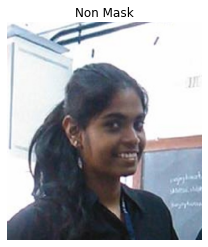

In [ ]:
#Using the view image function we randomly print an image from the non-mask file
img = view_image("/content/New Masks Dataset/Train/","Non Mask")

['1340.jpg']
image shape (900, 598, 3)


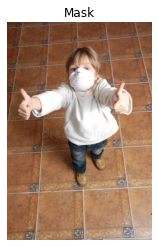

In [ ]:
#Using the view image function we randomly print an image from the mask file
img = view_image("/content/New Masks Dataset/Train/","Mask")

In [ ]:
#Read the data 
#Two lists are created: one for images and one for labels
#Using Non-Mask file
data=[]
labels=[]
no_mask=os.listdir("/content/New Masks Dataset/Train/Non Mask/")
for a in no_mask:

    image = cv2.imread("/content/New Masks Dataset/Train/Non Mask/"+a,)
    image = cv2.resize(image, (224, 224))


    data.append(image)
    labels.append(0)

no_mask=os.listdir("/content/New Masks Dataset/Test/Non Mask/")
for a in no_mask:

    image = cv2.imread("/content/New Masks Dataset/Test/Non Mask/"+a,)
    image = cv2.resize(image, (224, 224))


    data.append(image)
    labels.append(0)

In [ ]:
#Read the data 
#Two lists are created: one for images and one for labels
#Using Mask file
mask=os.listdir("/content/New Masks Dataset/Train/Mask/")
for a in mask:

    image = cv2.imread("/content/New Masks Dataset/Train/Mask/"+a,)
    image = cv2.resize(image, (224, 224))


    data.append(image)
    labels.append(1)


mask=os.listdir("/content/New Masks Dataset/Test/Mask/")
for a in mask:

    image = cv2.imread("/content/New Masks Dataset/Test/Mask/"+a,)
    image = cv2.resize(image, (224, 224))


    data.append(image)
    labels.append(1)

In [ ]:
#Convert the list of images and labels into numpy array
#Divide the images by 255 to scale them
data = np.array(data) / 255.0
labels = np.array(labels)

In [ ]:
data.shape

(700, 224, 224, 3)

# Creating the MobileNet model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42,shuffle=True,
                                                    stratify = labels)

In [ ]:
#Transfer learning 
#We apply MobileNet to train the model
base_model = tf.keras.applications.MobileNet(input_shape=[224,224,3], weights = "imagenet", include_top=False)

base_model.trainable = False

for layer in base_model.layers[30:]:
  layer.trainable = False
    

model = Flatten()(base_model.output)
model = Dense(units=256, activation="relu")(model)
model = Dense(units=64, activation="relu")(model)
prediction_layer = Dense(units=1, activation="sigmoid")(model)

model = Model(inputs = base_model.input, outputs = prediction_layer)
model.compile(optimizer='SGD',loss='binary_crossentropy',metrics=['accuracy'])

17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
with tf.device('/GPU:0'):
  results = model.fit(X_train, y_train, epochs=10, validation_split= 0.1, batch_size=32)

Epoch 1/10
16/16 [==============================] - 10s 95ms/step - loss: 0.6204 - accuracy: 0.8651 - val_loss: 0.0418 - val_accuracy: 0.9821
Epoch 2/10
16/16 [==============================] - 1s 49ms/step - loss: 0.0125 - accuracy: 0.9980 - val_loss: 0.0302 - val_accuracy: 1.0000
Epoch 3/10
16/16 [==============================] - 1s 44ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0297 - val_accuracy: 0.9821
Epoch 4/10
16/16 [==============================] - 1s 44ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 1.0000
Epoch 5/10
16/16 [==============================] - 1s 44ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0230 - val_accuracy: 1.0000
Epoch 6/10
16/16 [==============================] - 1s 43ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0226 - val_accuracy: 1.0000
Epoch 7/10
16/16 [==============================] - 1s 44ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0214 - val_accuracy: 1.0000
Epoch 8/10
1

In [ ]:
# history from 10 epochs that were ran by a model (loss, accuracy, validation loss, validation accuracy)
results.history

{'loss': [0.6203802227973938,
  0.012514476664364338,
  0.004328794777393341,
  0.0028367461636662483,
  0.0020828472916036844,
  0.0016578210052102804,
  0.001371814520098269,
  0.0011755629675462842,
  0.001019060262478888,
  0.0009006730979308486],
 'accuracy': [0.8650793433189392,
  0.9980158805847168,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.0417877621948719,
  0.03023483417928219,
  0.029749521985650063,
  0.024359315633773804,
  0.023003606125712395,
  0.022571073845028877,
  0.02143763191998005,
  0.02094285562634468,
  0.020699921995401382,
  0.020200442522764206],
 'val_accuracy': [0.9821428656578064,
  1.0,
  0.9821428656578064,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]}

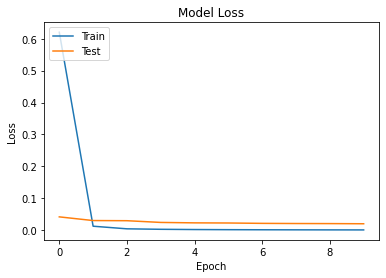

In [ ]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

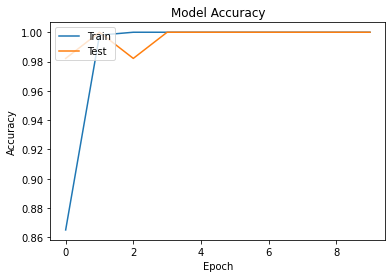

In [ ]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

In [ ]:
#Predicting based on test data
predictions = model.predict(X_test)
predictions

5/5 [==============================] - 1s 108ms/step


array([[5.2305215e-05],
       [4.2803562e-04],
       [9.9997294e-01],
       [1.3067230e-05],
       [9.9998772e-01],
       [9.9996984e-01],
       [9.9969172e-01],
       [9.9982411e-01],
       [9.9995804e-01],
       [3.7093730e-05],
       [9.9991131e-01],
       [9.9986899e-01],
       [9.9994373e-01],
       [9.9997401e-01],
       [9.9998283e-01],
       [2.1954144e-04],
       [4.6399608e-04],
       [2.3986378e-05],
       [3.4013013e-03],
       [1.1081524e-04],
       [1.6184244e-04],
       [9.9286415e-05],
       [6.7653658e-04],
       [8.7854779e-01],
       [9.9974293e-01],
       [1.0349830e-04],
       [9.9998665e-01],
       [9.9337727e-01],
       [9.9976712e-01],
       [9.9999893e-01],
       [3.4715663e-04],
       [9.9997830e-01],
       [9.9998355e-01],
       [1.1153192e-02],
       [2.1770543e-04],
       [9.9988985e-01],
       [9.9315029e-01],
       [9.9990952e-01],
       [7.7974473e-05],
       [1.1770598e-04],
       [9.9696332e-01],
       [1.679157

In [ ]:
#Convert the predictions to 0 & 1 to print the confiusion matrix
predictions = model.predict(X_test)

predict=[]

for i in range(len(predictions)):
    if predictions[i][0]>0.5:
        predict.append(1)
    else:
        predict.append(0)

5/5 [==============================] - 0s 52ms/step


In [ ]:
pd.DataFrame(confusion_matrix(y_test, predict), columns= ["No Mask", "Mask"], index = ["No Mask", "Mask"])

,No Mask,Mask
No Mask,67,3
Mask,0,70


# Save the trained model

In [ ]:
#Save the model
model_name = "/content/mask_detection.h5"
tf.keras.models.save_model(model, model_name)

# Part 2

**Using our saved model & haar-cascade classifier to build the detection system, via video or real time camera**

In [ ]:
import cv2
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

%config Completer.use_jedi = False

# Uploading the Haar Cascade classifier & the pre-trained model

In [ ]:
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
mask_detection = tf.keras.models.load_model("/content/mask_detection.h5")

In [ ]:
text_mask = "Mask On"
text_no_mask = "Mask Off"
font = cv2.FONT_HERSHEY_SIMPLEX
scale = 0.8

In [ ]:
#We create a function that transforms the images
def predict(image):
    
    face_frame = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    face_frame = cv2.resize(face_frame, (224, 224))
    face_frame = img_to_array(face_frame)
    face_frame = np.expand_dims(face_frame, axis=0)
    face_frame =  preprocess_input(face_frame)
    prediction = mask_detection.predict(face_frame)
    
    return prediction[0][0]

In [ ]:
def detector(gray_image, frame):
    
    faces = face_classifier.detectMultiScale(gray_image, 1.1, 5)
    
    for (x,y,w,h) in faces:

        roi_color = frame[y:y+h, x:x+w]
        mask = predict(roi_color)

        
        if mask > 0.5:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0,255,0), 2)
            cv2.putText(frame, text =text_mask, org =(x+50,y-100), fontFace =font, fontScale = scale, color =(0,255,0),
            thickness = 2)
        
        elif mask<=0.5:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0,0,255), 2)
            cv2.putText(frame, text =text_no_mask, org =(x+50,y-100), fontFace =font, fontScale = scale , color =(0,0,255),
            thickness = 2)
            
    return frame

# Run the detection system using video or camera

In [ ]:
#To detect face masks using a video
%matplotlib inline
video_cap = cv2.VideoCapture('video1.mp4')

while True:
    
    ret, frame = video_cap.read()
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    detect = detector(gray_frame, frame)
    
    cv2.imshow("Video", detect)
    
    
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
        
video_cap.release()
cv2.destroyAllWindows()

In [ ]:
#Our detection model is more robust using the camera
#To detect face masks using the camera
%matplotlib inline
video_cap = cv2.VideoCapture(0)

while True:
    
    ret, frame = video_cap.read()
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    detect = detector(gray_frame, frame)
    
    cv2.imshow("Video", detect)
    
    
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
        
video_cap.release()
cv2.destroyAllWindows()

# Real-world application

**Real-world application for our detection system**

Recently and after the spreading of COVID-19 worldwide Lockdowns happened due to the COVID-19 outbreak, Face masks became mandatory for everyone while roaming outside. Using Computer vision to detect whether a person is wearing a mask or not. can help to keep him safe and everybody in the place. and in our crowded world having something like COVID-19 again is expected.